# Synthetic data


In [1]:
import numpy as np
from matplotlib import rcParams
import healpy as hp
import matplotlib.pyplot as plt

# paralelizacion
import multiprocessing
from multiprocessing import Pool
from functools import partial

rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 50
rcParams["font.size"] = 15


In [2]:
loc_lcparam = 'datos/Pantheon+SH0ES.dat.txt' 
lcparam = np.loadtxt(loc_lcparam, skiprows=1,
                     usecols=(2, 8, 9, 10, 11, 26, 27))
# save indices of redshifts < 0.1
ind = np.where(lcparam[:, 0] < 0.1)[0]

zz = lcparam[ind, 0]
mz = lcparam[ind, 1]
sigmz = lcparam[ind, 2]
muz = lcparam[ind, 3]
sigmuz = lcparam[ind, 4]
ra = lcparam[ind, 5]
dec = lcparam[ind, 6]

print("We have", len(zz), "SNe with z < 0.1")


We have 741 SNe with z < 0.1


In [3]:
def dl(z, h0, q0):  # cosmographic luminous distance
    y = z/(z+1.0)
    # cambiar la velocidad de la luz	 por valor exacto !
    return (3000.0/h0)*(y+(3.0-q0)*np.pow(y, 2)/2.0)

# distance modulus


def mu(z, h0, q0):
    return 5.0*np.log10(dl(z, h0, q0))+25.0


### Queremos crear una muestra sintética de datos distribuidos en toda la esfera celeste.

La manera más intuitiva es generar datos aleatorios para dec y ra, de la siguiente manera

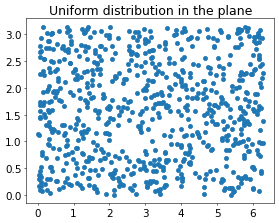

In [4]:
rai_fail= np.random.uniform(0, 2*np.pi, len(ra))
deci_fail= np.random.uniform(0, np.pi, len(dec))


plt.scatter(rai_fail, deci_fail) #s=1 is the size of the dots
plt.title('Uniform distribution in the plane')
plt.show()

Parecieran estar distribuidos uniformemente!

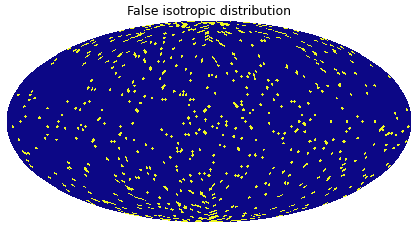

In [8]:
nsources = len(ra)
nside= 32
npix = hp.nside2npix(nside)
indices = hp.ang2pix(nside, deci_fail, rai_fail)

hpxmap = np.zeros(npix, dtype=float)
np.add.at(hpxmap, indices, 1)
# cmap ="coolwarm" or "jet" or "viridis" or "plasma" or "inferno" or "magma" or "cividis"
hp.mollview(hpxmap, title='False isotropic distribution', cbar=False , unit='Supernovae map', norm='hist', cmap='plasma', min=0, max=1)
#plt.savefig('false isotropic_distribution.png')

### En realidad, las supernovas se acumulan en los polos! 
Tenemos que corregir esto

Para ello, generamos tres puntos aleatorios distribuidos normalmente y con ellos formamos un vector. Este vector intuitivamente tiene una dirección aleatoria el espacio pero no está situado en la esfera. Si normalizamos el vector entonces tendremos un vector que apunta en una direccion aleatoria  y que yace en la esfera.

In [9]:
vecti = np.random.randn(len(ra), 3) #three random numbers vector (x,y,z) 
vecti /= np.linalg.norm(vecti, axis=1)[:, np.newaxis] # normalize the vector

thetai = np.arccos(vecti[:,2])
phii = np.arctan2(vecti[:,1], vecti[:,0])

deci = thetai
rai = np.pi - phii


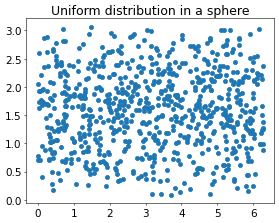

In [10]:
plt.scatter(rai, deci) #s=1 is the size of the dots
plt.title('Uniform distribution in a sphere')
plt.show()

# Mollview

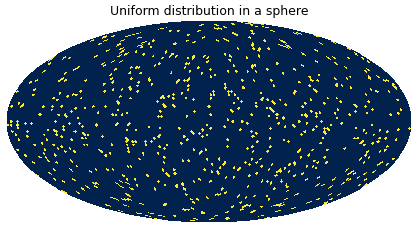

In [11]:
rcParams["figure.dpi"] = 50
n_sources = len(ra)
nside= 32
npix = hp.nside2npix(nside)
indicesi = hp.ang2pix(nside, deci, rai)

hpmapi = np.zeros(npix)
np.add.at(hpmapi, indicesi, 1)
hp.mollview(hpmapi, title='Uniform distribution in a sphere',cbar=False, unit='supernovae',min=0, max=1,cmap="cividis")
#plt.savefig('uniform distribution in a sphere.png')

Abajo tenemos la distribución original de las supernovas a modo de comparación.

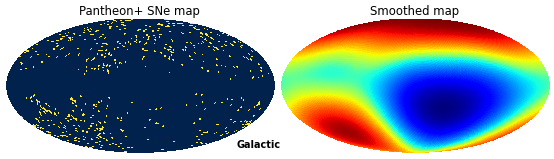

In [12]:
rcParams["font.size"] = 14
n_sources = len(ra)
nside = 32  # You can choose an appropriate value for nside
npix = hp.nside2npix(nside)
indices_sn = hp.ang2pix(nside, np.pi / 2 - np.radians(dec), np.radians(ra))

snmap = np.zeros(npix, dtype=float)
np.add.at(snmap, indices_sn, 1)

# Smooth the snmap with a FWHM of 180 degrees
smoothed_map = hp.smoothing(snmap, fwhm=np.radians(80))


# Create a figure with two subplots

fig = plt.figure(figsize=(11, 4))
# Plot the original map in the first subplot (left)
hp.mollview(snmap, title=r"Pantheon+ SNe map", cbar=False, norm="hist", cmap="cividis", coord="cg",sub=(1,2,1) ,fig=1, min=0, max=1)


# Plot the smoothed map in the second subplot (right)
hp.mollview(smoothed_map, title=r"Smoothed map", cbar=False, norm="hist", notext=True, cmap="jet", coord="cg",sub =(1,2,2), fig=2, min=0, max=1)
#plt.savefig('Supernovae map Pantheon+0.0<z<0.1.png')
plt.show()



<a id="LCDM"></a>
# Módulos de distancia consistentes con LCDM

En este set de datos sintéticos cambiamos el módulo de distancia de cada supernova por uno sampleado de una distribución normal centrada en $\mu_{fid}$ y con desviación estándar $\sigma$ correspondiente al error original del módulo de distancia de cada supernova.



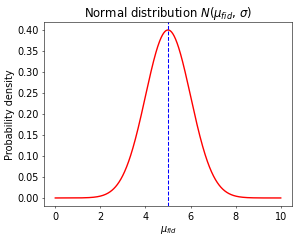

In [22]:
# Define the mean and standard deviation of the normal distribution
mu = 5
sigma = 1


# Add a line for the normal distribution density function
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 1000)
plt.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2)),
         color='red', linewidth=2)

# Add a dashed line to indicate the center of the distribution
plt.axvline(mu, color='blue', linestyle='--')

# Add labels and title to the plot
plt.xlabel(r"$\mu_{fid}$")
plt.ylabel('Probability density')
plt.title(r"Normal distribution $N(\mu_{fid}$, $\sigma)$")
plt.savefig('normal_distribution.png')
plt.show()


# Real SNe map in cartsesian projection
    

Text(0, 0.5, 'Declination')

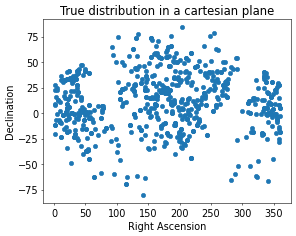

In [23]:
plt.scatter(ra, dec) #s=1 is the size of the dots
plt.title('True distribution in a cartesian plane')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')